<a href="https://colab.research.google.com/github/phutdi/HW/blob/master/disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pickle
import cv2


os.environ['KAGGLE_USERNAME'] = "phutdi"
os.environ['KAGGLE_KEY'] = "4eb6745d47557287a97b274bb72fa6c9"
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia


chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
from zipfile import ZipFile

file1 = ZipFile('chest-xray-pneumonia.zip', 'r')
file1.extractall()
file1.close()
file2 = ZipFile('chest_xray.zip', 'r')
file2.extractall()
file2.close()


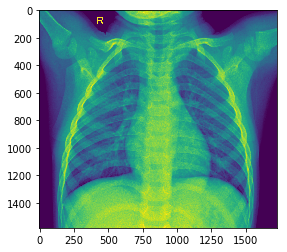

In [20]:
import matplotlib.image as mpimg
import shutil
import urllib.request
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, \
  GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3, \
  preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, \
  ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight

from itertools import product
from functools import partial


train_dir = '/content/chest_xray/train/'
validation_dir = '/content/chest_xray/val/'
test_dir = '/content/chest_xray/test/'

img = mpimg.imread(train_dir + '/NORMAL/IM-0135-0001.jpeg')
imgplot = plt.imshow(img)
plt.show()


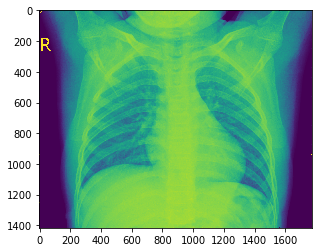

In [21]:
img = mpimg.imread(validation_dir + '/NORMAL/NORMAL2-IM-1427-0001.jpeg')
imgplot = plt.imshow(img)
plt.show()

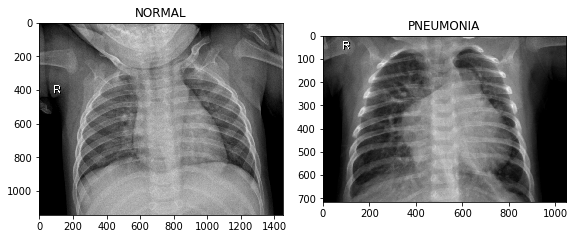

In [22]:
img_normal = plt.imread(f'{train_dir}NORMAL/IM-0131-0001.jpeg')
img_penumonia_bacteria = plt.imread(f'{train_dir}PNEUMONIA/person1017_bacteria_2948.jpeg')

plt.figure(figsize=(12, 5))

plt.subplot(1,3,1).set_title('NORMAL')
plt.imshow(img_normal, cmap='gray')

plt.subplot(1,3,2).set_title('PNEUMONIA')
plt.imshow(img_penumonia_bacteria, cmap='gray')

plt.tight_layout()

In [23]:
NUM_CLASSES = 2


def create_model(input_shape):
  base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
  
  x = base_model.output
  x = GlobalAveragePooling2D(name='avg_pool')(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(256, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.3)(x)
  
  for layer in base_model.layers:
    layer.trainable = False
    
  predictions = Dense(NUM_CLASSES, activation='sigmoid')(x)
  model = Model(inputs=base_model.inputs, outputs=predictions)
  return model

model = create_model((150, 150, 3))

training_loss = tf.keras.metrics.Mean('training_loss', dtype=tf.float32)
training_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    'training_accuracy', dtype=tf.float32)
test_loss = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    'test_accuracy', dtype=tf.float32)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [24]:
model.trainable_weights
optimizer = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])
rescale = 1./255
target_size = (150, 150)
batch_size = 163
class_mode = 'categorical'


def dir_file_count(directory):
    return sum([len(files) for r, d, files in os.walk(directory)])


train_datagen = ImageDataGenerator(rescale=rescale,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=target_size,
                                                    class_mode=class_mode,
                                                    batch_size=batch_size,
                                                    shuffle=True)

val_datagen = ImageDataGenerator(rescale=rescale)
val_generator = val_datagen.flow_from_directory(validation_dir, 
                                                target_size=target_size,
                                                class_mode=class_mode,
                                                batch_size=dir_file_count(validation_dir),
                                                shuffle=False)

test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=target_size,
                                                  class_mode=class_mode,
                                                  batch_size=dir_file_count(test_dir),
                                                  shuffle=False)
y = train_generator.classes
labels = np.unique(y)

train_class_weights = compute_class_weight('balanced', labels, y)
print(train_class_weights)
history = model.fit_generator(train_generator,
                              steps_per_epoch=len(train_generator),
                              epochs=10,
                              verbose=1,
                              validation_data=val_generator,
                              validation_steps=len(val_generator),
                              class_weight=train_class_weights,
                              workers=20)

MODEL_FILE = 'pneumonia_v0.0.1.hd5'
model.save(MODEL_FILE)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
[1.9448173  0.67303226]
Epoch 1/10
32/32 [==============================] - 77s 2s/step - loss: 0.5888 - acc: 0.7349 - val_loss: 0.7309 - val_acc: 0.5000
Epoch 2/10
32/32 [==============================] - 50s 2s/step - loss: 0.4656 - acc: 0.7460 - val_loss: 0.6240 - val_acc: 0.5000
Epoch 3/10
32/32 [==============================] - 69s 2s/step - loss: 0.3797 - acc: 0.7864 - val_loss: 0.6490 - val_acc: 0.6875
Epoch 4/10
32/32 [==============================] - 70s 2s/step - loss: 0.3161 - acc: 0.8710 - val_loss: 1.3732 - val_acc: 0.6250
Epoch 5/10
32/32 [==============================] - 70s 2s/step - loss: 0.2697 - acc: 0.8936 - val_loss: 1.4614 - val_acc: 0.7500
Epoch 6/10
32/32 [==============================] - 70s 2s/step - loss: 0.2534 - acc: 0.8969 - val_loss: 1.5956 - val_acc: 0.6875
Epoch 7/10
32/32 [==============================] - 69s 2s/step - loss: 0

In [0]:
!mv {MODEL_FILE} '/content/chest_xray/'

In [0]:
model = tf.keras.models.load_model('/content/chest_xray/pneumonia_v0.0.1.hd5')

In [27]:
result = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

1/1 [==============================] - 9s 9s/step - loss: 1.7383 - acc: 0.6987
Loss     : 1.74  
Accuracy : 69.87%


In [0]:
import pandas as pd


test_generator.reset()
filenames = test_generator.filenames
nb_samples = len(filenames)

predict = model.predict_generator(test_generator, steps=nb_samples)
predicted_class_indices = np.argmax(predict, axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

filenames = test_generator.filenames
results = pd.DataFrame({"Filename": filenames,
                        "Predictions": predictions})

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

results